In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
def prepara_dataset(data, y_collumns, sep=','):
    
    # Acquiring dataset data and class data
    y = data.iloc[:,len(data.columns)-y_collumns: len(data.columns)]
    y = np.array(y)
    X = data.iloc[:,0:len(data.columns)-y_collumns]
    X = np.array(X)
    
    # Randomizing dataset
    indices = np.random.choice(len(X), len(X), replace=False)
    X_values = X[indices]
    y_values = y[indices]
    
    # Creating an alias to dataset -> dataset.X and dataset.Y
    dataset = namedtuple('datset', 'X Y')

    return dataset(X=X_values, Y=y_values)


class MLP:
    
    def __init__(self, hidden_units, n_classes, learning_rate, delta_error):
        self.hidden_units = hidden_units
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.delta_error = delta_error
    
    def train_test_split(self, dataset, train_size):              
        # Computing the lenght of dataset
        lenght = dataset.X.shape[0]

        # Split dataset into train and test
        x_train = dataset.X[0:int(train_size*lenght), :]
        y_train = dataset.Y[0:int(train_size*lenght), :]
        x_test = dataset.X[int(train_size*lenght):, :]
        y_test = dataset.Y[int(train_size*lenght):, :]

        # Creating an alias to train and test set
        dataset = namedtuple('datset', 'X Y')
        train = dataset(X=x_train, Y=y_train)
        test = dataset(X=x_test, Y=y_test)

        return train, test

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def predict(self, X):
        train = self.train
        test = self.test
        hidden_weights = self.hidden_weights
        output_weights = self.output_weights
        y_hat, _ = self.forward(X, hidden_weights, output_weights)
        return np.argmax(y_hat)
    
    def score(self):
        train = self.train
        test = self.test
        counter = 0
        for i in range(test.X.shape[0]):
            y_hat = self.predict(test.X[i,:])
            y = np.argmax(test.Y[i,:])
            if y == y_hat:
                counter += 1
        return counter/test.X.shape[0]
        
    def forward(self, x, hidden_weights, output_weights):
        f_net_h = []
        # Apllying the weights on the hidden units
        for i in range(len(hidden_weights)):
            # if is the first hidden unit
            if i == 0:
                net = np.matmul(x, hidden_weights[i][:,0:len(x)].transpose()) + hidden_weights[i][:,-1]
                f_net = self.sigmoid(net)
            # if is the second or more hidden unit
            else:
                net = np.matmul(f_net_h[i-1], hidden_weights[i][:,0:len(f_net_h[i-1])].transpose()) + hidden_weights[i][:,-1]
                f_net = self.sigmoid(net)
            # store f_net of hidden layers
            f_net_h.append(f_net) 

        # Computing the net function to the output layer
        net = np.matmul(f_net_h[len(f_net_h)-1],output_weights[:,0:len(f_net_h[len(f_net_h)-1])].transpose()) + output_weights[:,-1]  
        f_net_o = self.sigmoid(net)

        return f_net_o, f_net_h

    def backward(self, dataset, j, hidden_weights, output_weights, f_net_o, f_net_h, eta, hidden_units, momentum_h, momentum_o, n_classes):
        x = dataset.X[j,:]
        y = dataset.Y[j,:]

        # Measuring the error
        error = y - f_net_o

        delta_o = error*f_net_o*(1-f_net_o)

        # Computing the delta for the hidden units
        delta_h = []
        for i in range(len(hidden_units)-1, -1, -1):
            if i == len(hidden_units)-1:
                w_o = output_weights[: ,0:hidden_units[i]]
                delta = (f_net_h[i]*(1-f_net_h[i]))*(np.matmul(delta_o, w_o))
            else:
                w_o = hidden_weights[i+1][:,0:hidden_units[i]]
                delta = (f_net_h[i]*(1-f_net_h[i]))*(np.matmul(delta, w_o))

            delta_h.insert(0,delta)

        # Computing the delta and updating weights for the output layer
        delta_o = delta_o[:, np.newaxis]
        f_net_aux = np.concatenate((f_net_h[len(hidden_units)-1],np.ones(1)))[np.newaxis, :]
        output_weights = output_weights - -2*eta*np.matmul(delta_o, f_net_aux) + momentum_o
        momentum_o = -(-2)*eta*np.matmul(delta_o, f_net_aux)

        # Updating the weights for the hidden layers
        for i in range(len(hidden_units)-1, -1, -1):
            delta = delta_h[i][:, np.newaxis]
            f_net_aux = np.concatenate((f_net_h[i],np.ones(1)))[np.newaxis, :]            
            if i == 0:
                x_aux = np.concatenate((x,np.ones(1)))[np.newaxis, :]
                hidden_weights[i] = hidden_weights[i] - -2*eta*np.matmul(delta, x_aux) + momentum_h[i]
                momentum_h[i] = -(-2)*eta*np.matmul(delta, x_aux)
            else:
                f_net_aux = np.concatenate((f_net_h[i-1],np.ones(1)))[np.newaxis, :]
                hidden_weights[i] = hidden_weights[i] - -2*eta*np.matmul(delta, f_net_aux) + momentum_h[i]
                momentum_h[i] = -(-2)*eta*np.matmul(delta, f_net_aux)

        # Measuring the error
        error = sum(error*error)

        # Returning the updated weights, the new error and the momentum parameters
        return hidden_weights, output_weights, error, momentum_h, momentum_o

    def fit(self, dataset, train_size, verbose=False):
        hidden_units = self.hidden_units
        n_classes = self.n_classes
        learning_rate = self.learning_rate
        delta_error = self.delta_error
        
        # Train-Test Split
        train, test = self.train_test_split(dataset, train_size)

        # Initializing the hidden layers and weights
        hidden_layers = len(hidden_units)
        momentum_o = 0
        momentum_h = []
        hidden_weights = []

        for i in range(hidden_layers):
            if i==0:
                aux = np.zeros((hidden_units[i], dataset.X.shape[1] + 1))
            else:
                aux = np.zeros((hidden_units[i], hidden_units[i-1] + 1))
            hidden_weights.append(aux)
            momentum_h.append(aux)

        # Filling the hidden layers weight values with a normal distribution between -1 and 1
        for i in range(hidden_layers):
            for j in range(hidden_units[i]):
                if i==0:
                    for k in range(dataset.X.shape[1] + 1):
                        hidden_weights[i][j][k] = random.uniform(-1, 1)
                else:
                    for k in range(hidden_units[i-1]+1):
                        hidden_weights[i][j][k] = random.uniform(-1, 1)

        # Initializing and filling the weights values of output layer
        output_weights = np.zeros((n_classes, hidden_units[len(hidden_units)-1]+1))
        for i in range(n_classes):
            for j in range(hidden_units[hidden_layers-1]+1):
                output_weights[i][j] = random.uniform(-1, 1)

        # Epochs
        if verbose:
            print('Epoch | Erro')
        epoch = 0
        errors_list = [1,0]
        delta = 10
        while(abs(delta) > delta_error):
            sum_errors = 0
            for i in range(1,train.X.shape[0]):
                # Forward
                f_net_o, f_net_h = self.forward(train.X[i,:], hidden_weights, output_weights)      
                # Backward
                hidden_weights,output_weights,error,momentum_h,momentum_o = self.backward(train,i,hidden_weights,output_weights,f_net_o,f_net_h,learning_rate,hidden_units,momentum_h,momentum_o,n_classes)
                sum_errors += error
            errors_list.append(sum_errors)
            delta = errors_list[-1] - errors_list[-2]
            if verbose:
                print(' ', epoch, '  |', sum_errors)
            epoch += 1
        
        if not verbose:
            print('Last epoch: {} | Error: {}'.format(epoch, sum_errors))
            
        self.hidden_weights = hidden_weights
        self.output_weights = output_weights
        self.train = train
        self.test = test

____
# Reconhecendo dígitos

Last epoch: 30 | Error: 16.37738115861724

Acurácia: 0.8849372384937239


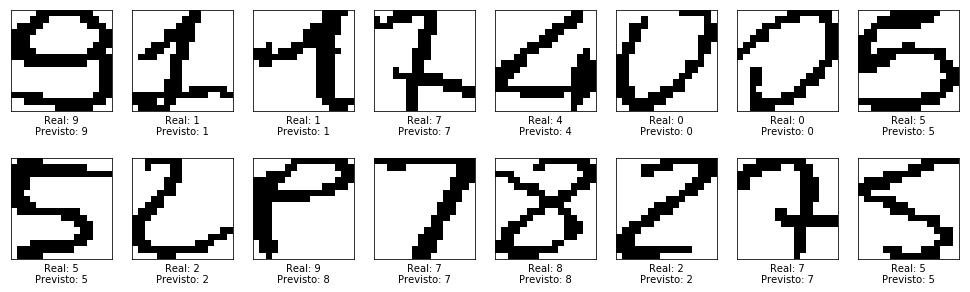

In [19]:
# Leitura do csv
df = pd.read_csv('semeion.data', sep=' ', lineterminator='\n', header=None)

# Preparação do dataset
digitos = prepara_dataset(df, 10)

# Treinamento da rede
mlp = MLP(hidden_units=[30], n_classes=10, learning_rate=0.5, delta_error=1e-2)
mlp.fit(digitos, train_size=0.7)

# Score
print('\nAcurácia:', mlp.score())

# Resultado
plt.figure(figsize=(17,5))
for i in range(1,17):
    plt.subplot(2,8,i)
    rand = np.random.randint(0, len(df)+1)
    real = np.argmax(digitos.Y[rand])
    pred = mlp.predict(digitos.X[rand])
    plt.imshow(digitos.X[rand].reshape(16,16), cmap='binary')
    plt.xlabel('Real: {}\nPrevisto: {}'.format(real, pred))
    plt.xticks([])
    plt.yticks([])
plt.show()